<a href="https://colab.research.google.com/github/AlexMa123/BIU-Computational-Physics-2022/blob/main/Lecture5%20-%20TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis

## Review

### What is time series analysis?

A time series is a series of data points indexed (or listed or graphed) in time order. `Time series analysis` comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. 

Usually, time series contains 3 componets: trend, periodic/seasonal, noise/residual.
$$y(t) = trend(t) + periodic(t) + noise(t)$$
or
$$y(t) = trend(t) \times periodic(t) \times noise(t)$$

|![example of time series decomposition](https://user-images.githubusercontent.com/21985915/43876851-62508334-9bc9-11e8-900e-8ba830c2678a.png)|
|:-:|
|*Example of time series decomposition*|



In [8]:
!pip install fbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Information from noise

#### 1. Autocorrelation

Autocorrelation function is defined as:
$$C(s) = \frac{E[(x_{t+s} - \mu)(x_t - \mu)]}{\sigma^2}$$

In [14]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from fbm import fgn, fbm
import numpy as np

In [15]:
def visual_noise(x):
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.title("noise")
    plt.plot(x)
    plt.subplot(132)
    plt.title("profile")
    plt.plot(np.cumsum(x))
    plt.subplot(133)
    plot_acf(x, ax=plt.gca())
    plt.show()

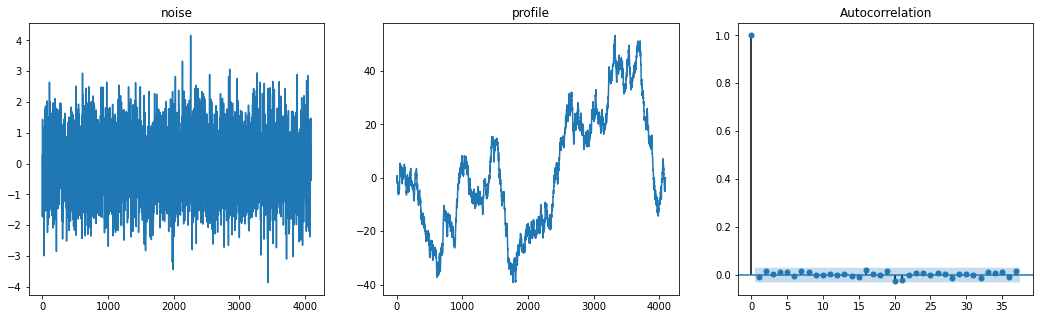

In [ ]:
# white noise 
# profile is the cumulative sum of the noise
# rxx(0) = 1, othercases = 0
x = np.random.randn(4096)
x = x - np.mean(x)
visual_noise(x)

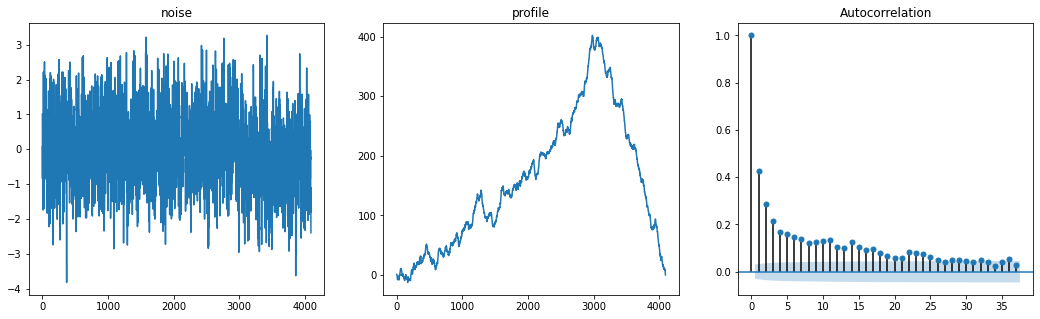

In [16]:
# positive autocorrelation
x = fgn(4096, hurst=0.75)
x = x - np.mean(x)
x = x / x.std()
visual_noise(x)

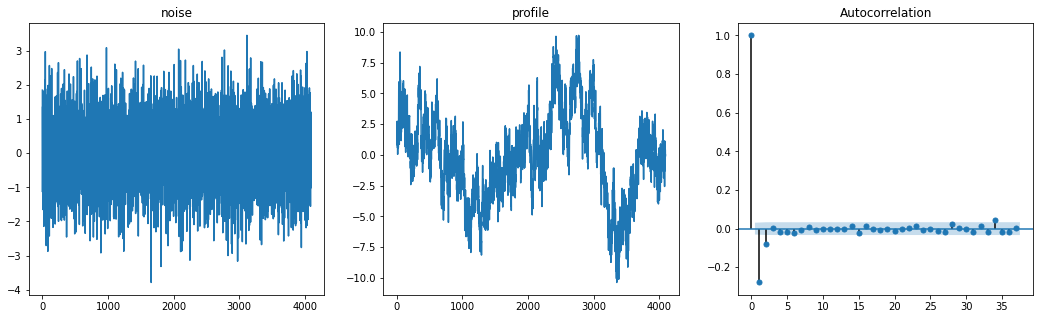

In [17]:
# negative autocorrelation
x = fgn(4096, hurst=0.25)
x = x - np.mean(x)
x = x / x.std()
visual_noise(x)

#### 2. correlation time

The correlation time is defined as: $\tau = \int_0^{\infty} s C(s)\mathrm{d}s$. 

If the integral is convergent, the time series is a short-term correlated series. Otherwise, the time series is a long-term correlated series.

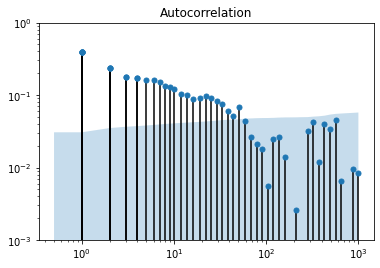

In [18]:
# example of long term correlation
# C(s) ~ s^(- gamma )
# very noisy tail (large s)
x = fgn(4096, hurst=0.75)
plot_acf(x, lags=np.logspace(0, 3, 50))
plt.ylim(0.001, 1)
plt.xscale('log')
plt.yscale('log')
plt.show()

#### 3. Self-affinity

`Self-affinity` is a feature of a fractal whose pieces are scaled by different amounts in the x- and y-directions. In the case of time series, the x axis will be time, and y axis will be your measurement.

Assume we have a time series y(t), the increment x(t, dt) is y(t + dt) - y(t). If the time series is a self-affine time series, the increment should keep the same distribution under different scales, which means:

$$|a|^H x(t, dt) \sim x(t, a dt)$$

$\sim$ means right-hand side and left-hand side have the same distribution

##### Hurst exponent for white noise.
If $x_0, x_1, x_2, \cdots, x_N$ are i.i.d (independent and identically distributed) and ***zero-mean*** random variables, because of the central limited theorem, for large scale, the increment will be a Gaussian distribution. 

$$Var[\sum_{i=0}^n x_i] = \sum_{i=0}^n Var[x_i]$$

So
$$\sigma[\sum_i x_i] = \sqrt{\sum_{i=0}^n Var[x_i] } = \sqrt{n \sigma^2} = \sqrt{n}\sigma $$

We can get H for white noise is 0.5

In [22]:
# Create random noise or fractional gaussian noise as x(t)
H = 0.75
t = np.arange(256000)
# x_t = np.random.randn(256000) # totally random
x_t = fgn(256000, hurst=H)
x_t = x_t - np.mean(x_t) # remove the mean value
x_t = x_t / x_t.std()

y_t = np.cumsum(x_t) # calculate the profile, y(t)
delta_t = []
sigma = []

For testing self-affinity, we can measure the profile under different scales. If under any given scale, the distribution of the increments keeps the same, and the width, or standard deviation increase power-lawly with the increase of scale, The time series is self-affine.

The power law exponent is `Hurst exponent`

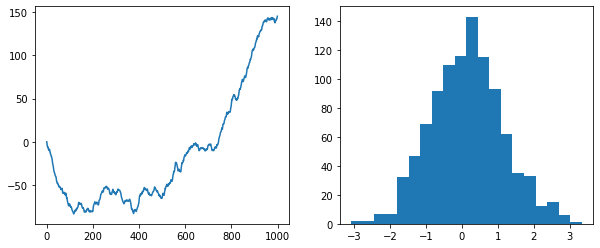

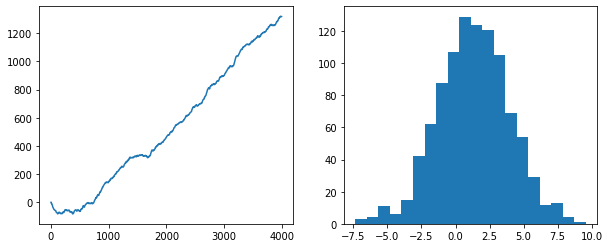

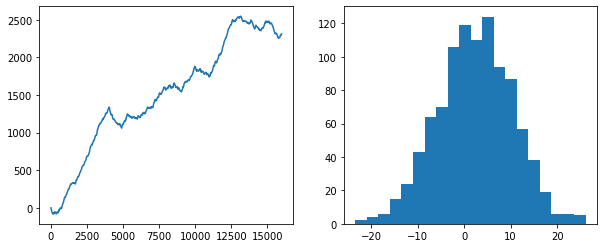

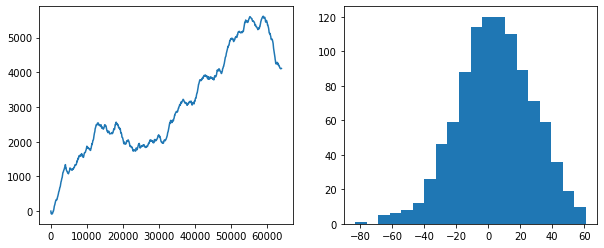

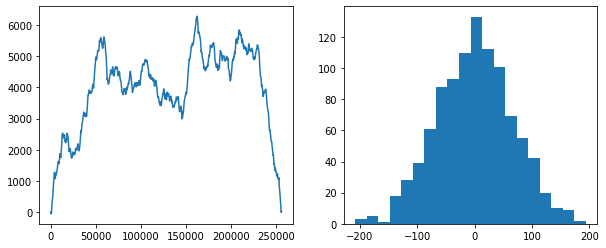

In [23]:
for step in [1, 4, 16, 64, 256]:
    sub_t = t[:1000 * step: step]
    sub_y = y_t[:1000 * step: step]

    dy = np.diff(sub_y)
    delta_t.append(step)
    sigma.append(dy.std())

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(sub_t, sub_y)
    plt.subplot(1, 2, 2)
    plt.hist(dy, bins=20)
    plt.show()

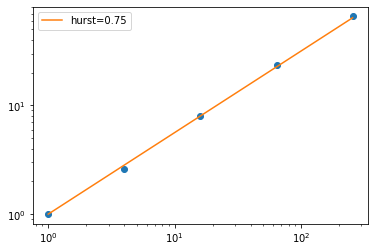

In [24]:
plt.plot(delta_t, sigma, 'o')
plt.plot(delta_t, np.array(delta_t) ** H  * sigma[0]/ delta_t[0] ** H, label=f'hurst={H}')
plt.legend()
plt.xscale('log')
plt.yscale('log')

#### Fluctuation Analysis
The steps we did above, is Fluctuation analysis:
1. remove the mean value in $x(t_i)$ and compute profile $y(t_j) = \sum_{i=0}^j x(t_i)$
2. Divide profile in segments of length (scale) s
3. Calculate the increments for each window, and calculate the standard deviation of the increments, dominated by F(s)
4. For a self-affine time series, $F(s) \sim s^{H}$

H = 0.5 means the increment is just white noise (random).

1 > H > 0.5 means the random walker can reach a farther point than the random case, this can only be true if the increment has a positive autocorrelation.

H < 0.5 then means the increment has a negative autocorrelation.

As we have seen in percolation when the autocorrelation is long-range, F(s) will be a straight line in the log-log plot. But when the autocorrelation is short-range, when the time scale is smaller than the correlation time, H will be different with 0.5. After the time scale becomes larger than the correlation time, H will be 0.5 (seems like random).

#### Detrended Fluctuation Analysis
But what if there is trend ? 

In [25]:
# Create random noise or fractional gaussian noise as x(t)
H = 0.5
t = np.arange(256000)
x_t = np.random.randn(256000) # totally random
# x_t = fgn(256000, hurst=H)
x_t = x_t + t * 1e-5
x_t = x_t - np.mean(x_t) # remove the mean value

y_t = np.cumsum(x_t) # calculate the profile, y(t)
delta_t = []
sigma = []

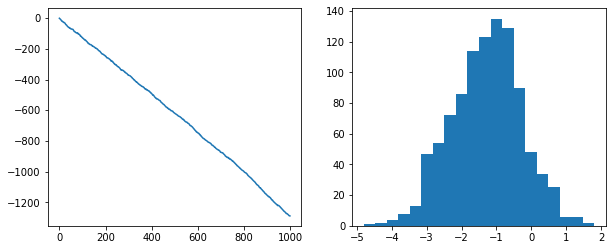

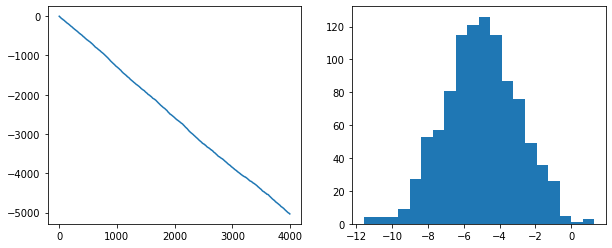

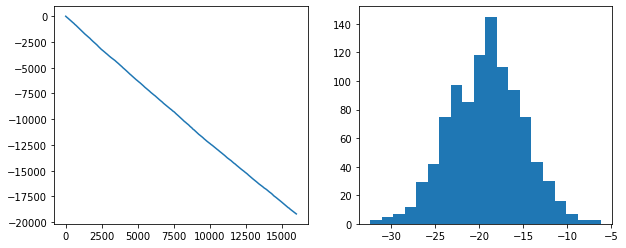

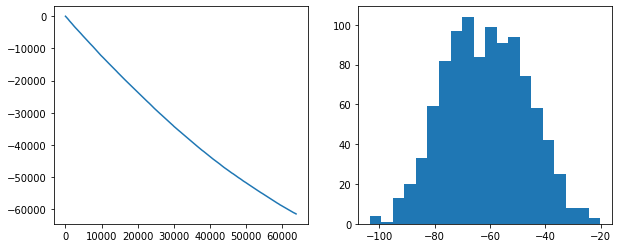

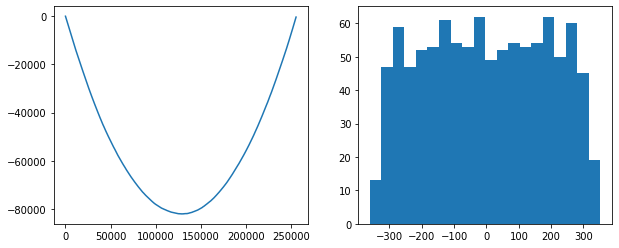

In [26]:
for step in [1, 4, 16, 64, 256]:
    sub_t = t[:1000 * step: step]
    sub_y = y_t[:1000 * step: step]

    dy = np.diff(sub_y)
    delta_t.append(step)
    sigma.append(dy.std())

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(sub_t, sub_y)
    plt.subplot(1, 2, 2)
    plt.hist(dy, bins=20)
    plt.show()

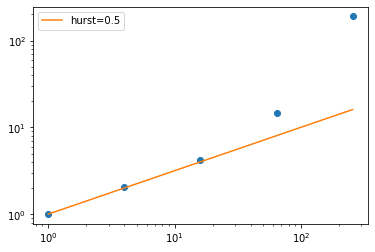

In [27]:
plt.plot(delta_t, sigma, 'o')
plt.plot(delta_t, np.array(delta_t) ** H  * sigma[0]/ delta_t[0] ** H, label=f'hurst={H}')

plt.legend()
plt.xscale('log')
plt.yscale('log')

Because of the trend, the slope is significantly different from the real hurst exponent, for fixing this, one can remove the trend from the profile. Usually, remove the polynoimal trend.

1. remove the mean value in $x(t_i)$ and compute profile $y(t_j) = \sum_{i=0}^j x(t_i)$
2. Divide profile in segments of length (scale) s
3. remove the trends from each segment.
4. Calculate the increments for each window, and calculate the standard deviation of the increments, dominated by F(s)
5. For a self-affine time series, $F(s) \sim s^{H}$


|![example of DFA](https://github.com/AlexMa123/BIU-Computational-Physics-2022/blob/main/img/TimeSeries/Illustration-of-Detrended-Fluctuation-Analysis-DFA-and-example-behavioral-time-series.ppm.png?raw=true)|
|:-:|
|*Example of DFA*|




### Fourier Transform
Discrete Fourier Transform (DFT) is defined as:
$$X_k = \sum_{n=0}^{N-1} x_n e^{- i \frac{2 \pi}{N} k n}$$

and $k = 0, 1, 2, \cdots N-1$. Fast Fourier Transform (FFT) is an fast algorithm that computes the DFT of a sequence.
#### Power Spectrum
The power spectrum is defined as: $S_k = \left| X_k \right|^2$. So $S_k = S_{N-k}$

$$f = k \frac{\text{sampling frequency}}{N}$$

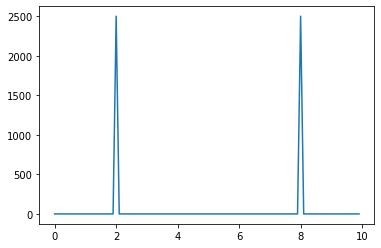

In [28]:
t = np.arange(0, 10, 0.1)
y = np.sin(2 * t * np.pi * 2)

fft_result = np.fft.fft(y)
power_spectrum = np.abs(fft_result) ** 2

freqs = np.arange(0, 10, 10 / y.size)
plt.figure()
plt.plot(freqs, power_spectrum)
# plt.xlim(0)

inverse Fourier Transform

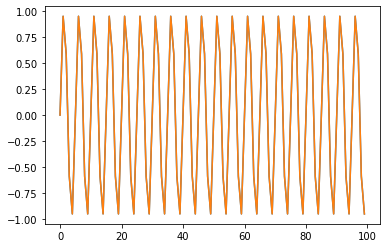

In [29]:
plt.plot(y)
plt.plot(np.fft.ifft(fft_result).real)

Also, the maximum frequency can be detected by DFA is half of the samplilng frequency

(-1.0, 1.0)

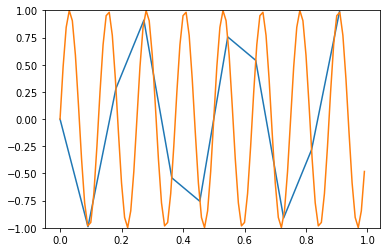

In [35]:
t = np.arange(0, 1, 1 / 11)
# lower the sampling frequency to see what will happen, 1 / 16, 1 / 12
y = np.sin(8 * t * np.pi * 2)

t_signal = np.arange(0, 1, 0.01)
y_signal = np.sin(8 * t_signal * np.pi * 2)
plt.plot(t, y)
plt.plot(t_signal, y_signal, label='original_signal')
plt.ylim(-1, 1)

#### Fourier Transform for self-affine time series
Remember what we did for check self-affinity： rescale the increment's time interval, and the process looks the same. The larger the time interval, in other words, smaller the sampling frequency, it's nothing but zoom into the low-frequency part of the power spectrum, and the power spectrum should keep the same.

$P(f)$ should looks the same with $P(a f)$. The only function meet this condition is power-law

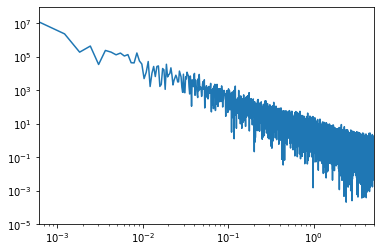

In [36]:
y = fbm(4096 * 4, hurst=0.5)
y = y - np.mean(y)
fft_result = np.fft.fft(y)
power_spectrum = np.abs(fft_result) ** 2
freqs = np.arange(0, 10, 10 / y.size)
plt.figure()
plt.plot(freqs, power_spectrum)
plt.xlim(freqs[1], 5)
plt.ylim(1e-5, 1e8)
plt.xscale('log')
plt.yscale('log')

#### Unevenly sampled data
Unevenly sampled data are quite common, examples include drill core data, astronomical observations, or stock price notations. But DFT can only estimate power spectrum from a evenly sampled data. For solving thie issue, we can use 1. interpolate or 2. Lomb-Scargle periodogram.

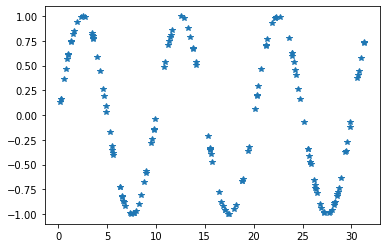

In [37]:
x = np.random.uniform(0, 10*np.pi, 150)
x = np.sort(x)
y = np.sin(x * 2 * np.pi / 10)
plt.plot(x, y, '*')

##### Interpolate

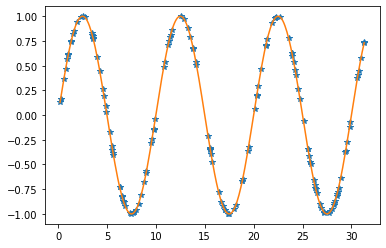

In [43]:
# interpolate
x_resample = np.arange(x[0], x[-1], 0.1)
from scipy.interpolate import interp1d
f = interp1d(x, y, kind='quadratic', assume_sorted=True)
y_resample = f(x_resample)
plt.plot(x, y, '*')
plt.plot(x_resample, y_resample)

Text(0.5, 0, 'frequency/Hz')

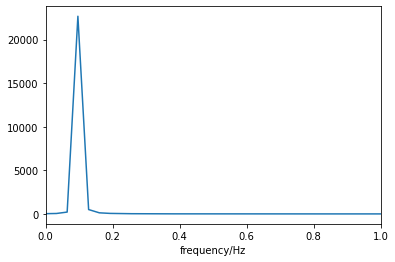

In [44]:
fft_result = np.fft.fft(y_resample)
power_spectrum = np.abs(fft_result) ** 2
freqs = np.arange(0, 10, 10 / y_resample.size)
plt.figure()
plt.plot(freqs, power_spectrum)
plt.xlim(0, 1)
plt.xlabel('frequency/Hz')

##### Lomb-scargle periodogram

Text(0.5, 0, 'frequency/Hz')

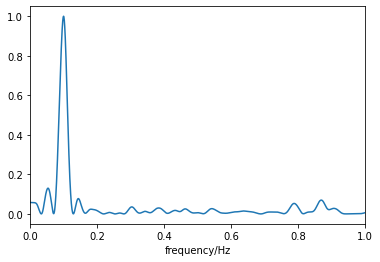

In [45]:
# Lomb-scargle periodogram
w = np.linspace(0.01, 10, 10000)
# #################################
# Note: W here is angular frequency
# #################################
import scipy.signal as signal
pgram = signal.lombscargle(x, y, w, normalize=True)
plt.plot(w / (np.pi * 2), pgram)
plt.xlim(0, 1)
plt.xlabel('frequency/Hz')

#### Non-stationary Signal
Power spectrum can't distinguish between stationary signal with non-stationary signal (frequency component changes with time). The most straight forward way to solve time is by using short-time Fourier transform (STFT): split the signal into overlap windows, calculate power spectrum for each windows

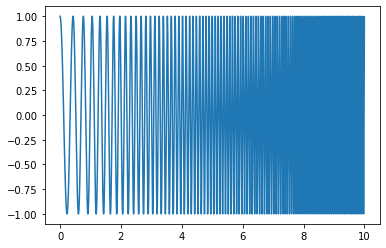

In [47]:
t = np.arange(0, 10, 0.001)
chirp_signal = signal.chirp(t, f0=2, t1=5, f1=10, method='linear')
plt.plot(t, chirp_signal)

Text(0, 0.5, 'freq/Hz')

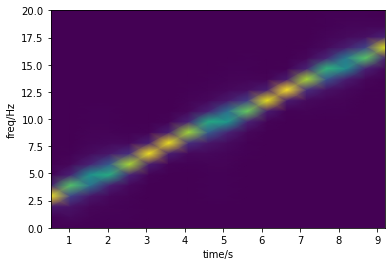

In [48]:
f, t, sxx = signal.spectrogram(chirp_signal, fs=1000, nperseg=1024, noverlap=512, window='boxcar')
plt.pcolormesh(t, f, sxx, shading='gouraud')
plt.ylim(0, 20)
plt.xlabel('time/s')
plt.ylabel('freq/Hz')

### Hilbert Transform
For a dynamical system has a limit circle in phase space, we can reduce the system by only one parameter, which is the phase. So for the signal that comes from a self-sustained system, describing the signal by phase can simplify our problems.

Hilbert transform is a transform that imparts a phase shift of $\pi / 2$ to every frequency component of a function, defined as:

$$  \operatorname {H} (s)(t)={\frac {1}{\pi }}\,\operatorname {p.v.} \int _{-\infty }^{+\infty }{\frac {s(\tau )}{t-\tau }}\;\mathrm {d} \tau $$

p.v. is the principle value.

Similar to a Lissajous curve, if we plot the signal s(t) as x axis, and $s_H(t)$ (or $\operatorname {H} (s)(t)$) as y axis. We can get a limit circle (if the signal comes from a self-sustained system)

Text(0, 0.5, '$s_H$')

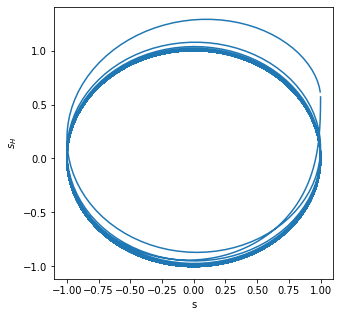

In [50]:
t = np.arange(0, 10, 0.001)
chirp_signal = signal.chirp(t, f0=2, t1=8, f1=10, method='linear')
from scipy.fftpack import hilbert
H_chirp_signal = hilbert(chirp_signal)
plt.figure(figsize=(5, 5))
plt.plot(chirp_signal, H_chirp_signal)
plt.xlabel("s")
plt.ylabel("$s_H$")

With (s, $s_H$), we can define the phase for each point.

(2.0, 8.0)

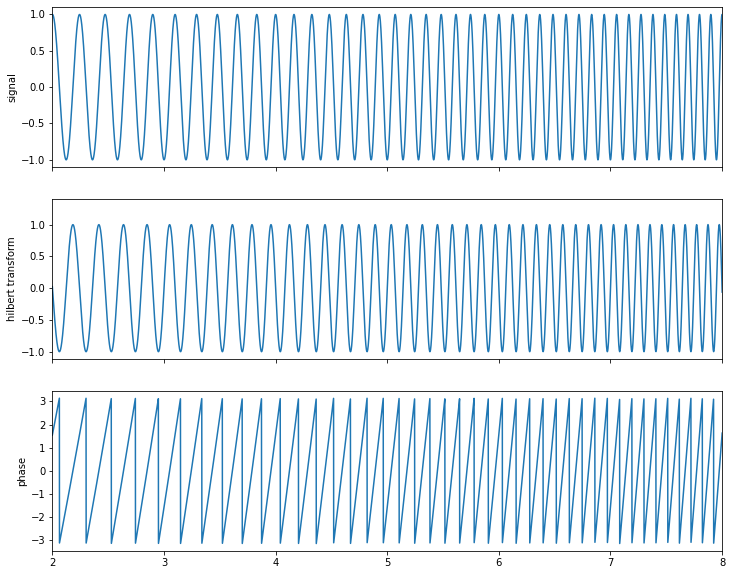

In [ ]:
phase = np.arctan2(chirp_signal, H_chirp_signal)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
axes[0].plot(t, chirp_signal)
axes[0].set_ylabel("signal")
axes[1].plot(t, H_chirp_signal)
axes[1].set_ylabel("hilbert transform")
axes[2].plot(t, phase)
axes[2].set_ylabel("phase")
plt.xlim(2, 8)

#### Phase synchronization
When two self-sustained systems weakly coupled together, phase synchronization will happen, which means the phase difference between this two system is stable:

$$\left| \phi_1(t) - \phi_2(t) - \delta \right| < const$$
where $\delta$ is some (average) phase shift.

By quantify the phase synchronization, there are lots of measurments. One of the methods is by checking the Fourier mode of the phase difference distribution:
$$\gamma^2 = \left< \cos \Psi(t)\right>^2 + \left< \sin \Psi(t)\right>^2$$

where $\Psi(t)$ is the phase difference. $\gamma$ will be 1 for a fully synchronized state, and 0 for an uncoupled case

In [58]:
def gamma(phase_diff):
    gamma2 = np.cos(phase_diff).mean() ** 2 + np.sin(phase_diff).mean() ** 2
    return np.sqrt(gamma2)

gamma(np.random.rand(10000) * 2 * np.pi)

0.014688150625992661

In [59]:
gamma(np.random.randn(100))

0.6061453599736757

## Exercise

## 1. Summarize what you have learned

## 2. Detrended Fluctuation Analysis (DFA)

Check whether the time series in ./DFA_data folder are positive/negative autocorrelated, or just random by using DFA.


In [60]:
# Download the data
!wget https://github.com/AlexMa123/BIU-Computational-Physics-2022/raw/main/DFA_data.zip
!unzip DFA_data.zip

--2022-06-08 12:20:30--  https://github.com/AlexMa123/BIU-Computational-Physics-2022/raw/main/DFA_data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexMa123/BIU-Computational-Physics-2022/main/DFA_data.zip [following]
--2022-06-08 12:20:31--  https://raw.githubusercontent.com/AlexMa123/BIU-Computational-Physics-2022/main/DFA_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15293333 (15M) [application/zip]
Saving to: ‘DFA_data.zip’

DFA_data.zip        100%[===================>]  14.58M  --.-KB/s    in 0.1s    

2022-06-08 12:20:31 (129 MB/s) - ‘DFA_data.zip’ saved [15293333/15293

In [ ]:
# There are four time series, A B C D
!ls DFA_data

A  B  C  D


In [61]:
import numpy as np
# load the data:
data_A = np.loadtxt('./DFA_data/A')
data_A

array([ -1.03790971,  26.92149282, -14.08130474, ...,   4.27924185,
       -12.22550925, -44.05686112])

In [62]:
import pandas as pd
# fill your results in these two lists
hursts = [0, 0, 0, 0]
ac = ['R', 'R', 'R', 'R'] # fill 'P' (positive), 'N' (negative) or 'R' (random)

pd.DataFrame(
    {
        'Hurst exponent': hursts,
        'autocorrelation': ac
    }
    , index=['A', 'B', 'C', 'D']
)

,Hurst exponent,autocorrelation
A,0,R
B,0,R
C,0,R
D,0,R


## 3. Respiratory Sinus Arrhythmia (RSA) 
* Install the App `phyphox` on your phone.  https://phyphox.org/download/

* Lie in bed and put your phone on your chest

* Open the app `phyphox`, choose `Acceleration with g` and start recording.

* Record for 5 mins, then stop it and Export Data as `CSV (Comma, decimal point)`

* Upload the zip to Colab and do analysis.

Your analysis should be similiar with this example:

https://github.com/AlexMa123/BIU-Computational-Physics-2022/blob/main/example_of_RSA.pdf

In [ ]:
# upload your file to colab
from google.colab import files
uploaded = files.upload()

In [65]:
# You will get a zip file from phyphox
# upload the zip file to colab
!unzip g\ 2022-06-07\ 15-57-56.zip # Unzip the zip file.
# Remember to change to your own file's name
# The data is saved in Raw Data.csv

Archive:  g 2022-06-07 15-57-56.zip
  inflating: Raw Data.csv            
  inflating: meta/device.csv         
  inflating: meta/time.csv           


### Load the data

In [66]:
import pandas as pd
import numpy as np

def bandpass_filter(x, band, fs=100):
    """
    band pass filter
    x (numpy array): raw signal
    band (List): [low frequency band, high frequency band]
    fs (int): sampling frequency
    """
    from numpy.fft import rfft, irfft
    fft_result = rfft(x)
    delta_f = fs / x.size
    start_i = int(band[0] / delta_f)
    end_i = int(band[1] / delta_f)
    fft_result[:start_i] = 0
    fft_result[end_i:] = 0
    return irfft(fft_result, n=x.size)

In [67]:
# read csv
df = pd.read_csv("Raw Data.csv")
df

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.014546,-1.583450,7.928020,5.780461,9.938538
1,0.016950,-1.502094,7.935198,5.797211,9.941394
2,0.019354,-1.456631,7.959126,5.773283,9.939832
3,0.021758,-1.372882,7.975876,5.763711,9.935782
4,0.024162,-1.356132,7.947162,5.713462,9.881302
...,...,...,...,...,...
5127,12.339462,-1.344168,5.013562,7.838289,9.401136
5128,12.341866,-1.289133,5.020740,7.833503,9.393267
5129,12.344270,-1.217349,5.015954,7.761718,9.321266
5130,12.346674,-1.162314,5.078168,7.759326,9.345903


In [68]:
# convert pandas series to numpy array
t = df.iloc[:, 0].values
acc_x = df.iloc[:, 1].values
acc_y = df.iloc[:, 2].values
acc_z = df.iloc[:, 3].values